<center>
    <h1>Room Occupancy Estimation - DM, TM and BDA</h1>
    <h2>Data Analysis and Splitting</h2>
    <h3>Riccardo Spolaor</h3>
    <h4>riccardo.spolaor@studio.unibo.it</h4>
</center>

---
In this notebook the ***Room Occupancy Estimation*** dataset is analysed and Split into train and validation for predictive tasks.

The *Room Occupancy Estimation* dataset contains ground truth information about the number of people present in a $6m \times 4.6m$ room over time, varying from $0$ to $3$. Along with it, $16$ sensor data measurements are present at each time step. The measurements are in term of temperature, light, sound, CO2 and digital passive infrared (PIR).

The task of the experiment is to predict the number of people in a room considering the sensor data at the given timestep.

The dataset used in the work is the one presented at the following link: https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation.

The reference paper is available at the following link: https://www.semanticscholar.org/paper/e631ea26f0fd88541f42b4e049d63d6b52d6d3ac.

## Settings

In [ ]:
import sys

IS_COLAB = 'google.colab' in sys.modules

In [ ]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [ ]:
# Matplotlib settings

%matplotlib inline

## Libraries Installation

In [ ]:
if IS_COLAB:
    !pip install pyspark
    !pip install findspark

In [ ]:
import findspark


findspark.init()

In [ ]:
import pyspark.sql.functions as F

## Setting Spark Session

In [ ]:
from pyspark.sql import SparkSession


# Create a spark session
spark = SparkSession.builder.master('local[*]').appName('OccupancyEstimation').getOrCreate()

## Get the Dataset

In [ ]:
if not IS_COLAB:
    # Put the local file in the nodes.
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -mkdir /input
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -mkdir /input/raw
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -put input/raw/Occupancy_Estimation.csv /input/raw/Occupancy_Estimation.csv

In [ ]:
import os


if IS_COLAB:
    file_path = os.path.join('.', 'input', 'raw', 'Occupancy_Estimation.csv')
else:
    file_path = os.path.join('/', 'input', 'raw', 'Occupancy_Estimation.csv')

In [ ]:
df = spark.read.csv(
    file_path,
    header=True,
    inferSchema=True)

# Parse Date and Time Columns
df = df.withColumn('Date', F.to_date('Date', format="yyyy/MM/dd"))
df = df.withColumn('Time', F.to_timestamp('Time', format='HH:mm:ss'))

## Dataset Analysis

In [ ]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- S1_Temp: double (nullable = true)
 |-- S2_Temp: double (nullable = true)
 |-- S3_Temp: double (nullable = true)
 |-- S4_Temp: double (nullable = true)
 |-- S1_Light: integer (nullable = true)
 |-- S2_Light: integer (nullable = true)
 |-- S3_Light: integer (nullable = true)
 |-- S4_Light: integer (nullable = true)
 |-- S1_Sound: double (nullable = true)
 |-- S2_Sound: double (nullable = true)
 |-- S3_Sound: double (nullable = true)
 |-- S4_Sound: double (nullable = true)
 |-- S5_CO2: integer (nullable = true)
 |-- S5_CO2_Slope: double (nullable = true)
 |-- S6_PIR: integer (nullable = true)
 |-- S7_PIR: integer (nullable = true)
 |-- Room_Occupancy_Count: integer (nullable = true)



In [ ]:
print('Number of dataframe rows:', df.count())
df.show(n=5)

Number of dataframe rows: 10129
+----------+-------------------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------+--------------+------+------+--------------------+
|      Date|               Time|S1_Temp|S2_Temp|S3_Temp|S4_Temp|S1_Light|S2_Light|S3_Light|S4_Light|S1_Sound|S2_Sound|S3_Sound|S4_Sound|S5_CO2|  S5_CO2_Slope|S6_PIR|S7_PIR|Room_Occupancy_Count|
+----------+-------------------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------+--------------+------+------+--------------------+
|2017-12-22|2023-11-22 10:49:41|  24.94|  24.75|  24.56|  25.38|     121|      34|      53|      40|    0.08|    0.19|    0.06|    0.06|   390|0.769230769231|     0|     0|                   1|
|2017-12-22|2023-11-22 10:50:12|  24.94|  24.75|  24.56|  25.44|     121|      33|      53|      40|    0.93|    0.05|    0.06|    0.06|   390|0.646153846154|     0|     0|                   1

In [ ]:
df.summary().show()

+-------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+-------------------+-------------------+------------------+--------------------+-------------------+-------------------+--------------------+
|summary|           S1_Temp|           S2_Temp|            S3_Temp|           S4_Temp|          S1_Light|          S2_Light|         S3_Light|         S4_Light|           S1_Sound|           S2_Sound|           S3_Sound|           S4_Sound|            S5_CO2|        S5_CO2_Slope|             S6_PIR|             S7_PIR|Room_Occupancy_Count|
+-------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+-------------------+-------------------+------------------+--------------------+-------------------+----------------

In [ ]:
print('Number of duplicated rows:', df.count() - df.distinct().count())

Number of duplicated rows: 0


In [ ]:
print('Null values per column:')
df.select(
    [F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c)
    for c in df.columns if c not in ['Date', 'Time']]).show()

Null values per column:
+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------+------------+------+------+--------------------+
|S1_Temp|S2_Temp|S3_Temp|S4_Temp|S1_Light|S2_Light|S3_Light|S4_Light|S1_Sound|S2_Sound|S3_Sound|S4_Sound|S5_CO2|S5_CO2_Slope|S6_PIR|S7_PIR|Room_Occupancy_Count|
+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------+------------+------+------+--------------------+
|      0|      0|      0|      0|       0|       0|       0|       0|       0|       0|       0|       0|     0|           0|     0|     0|                   0|
+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------+------------+------+------+--------------------+



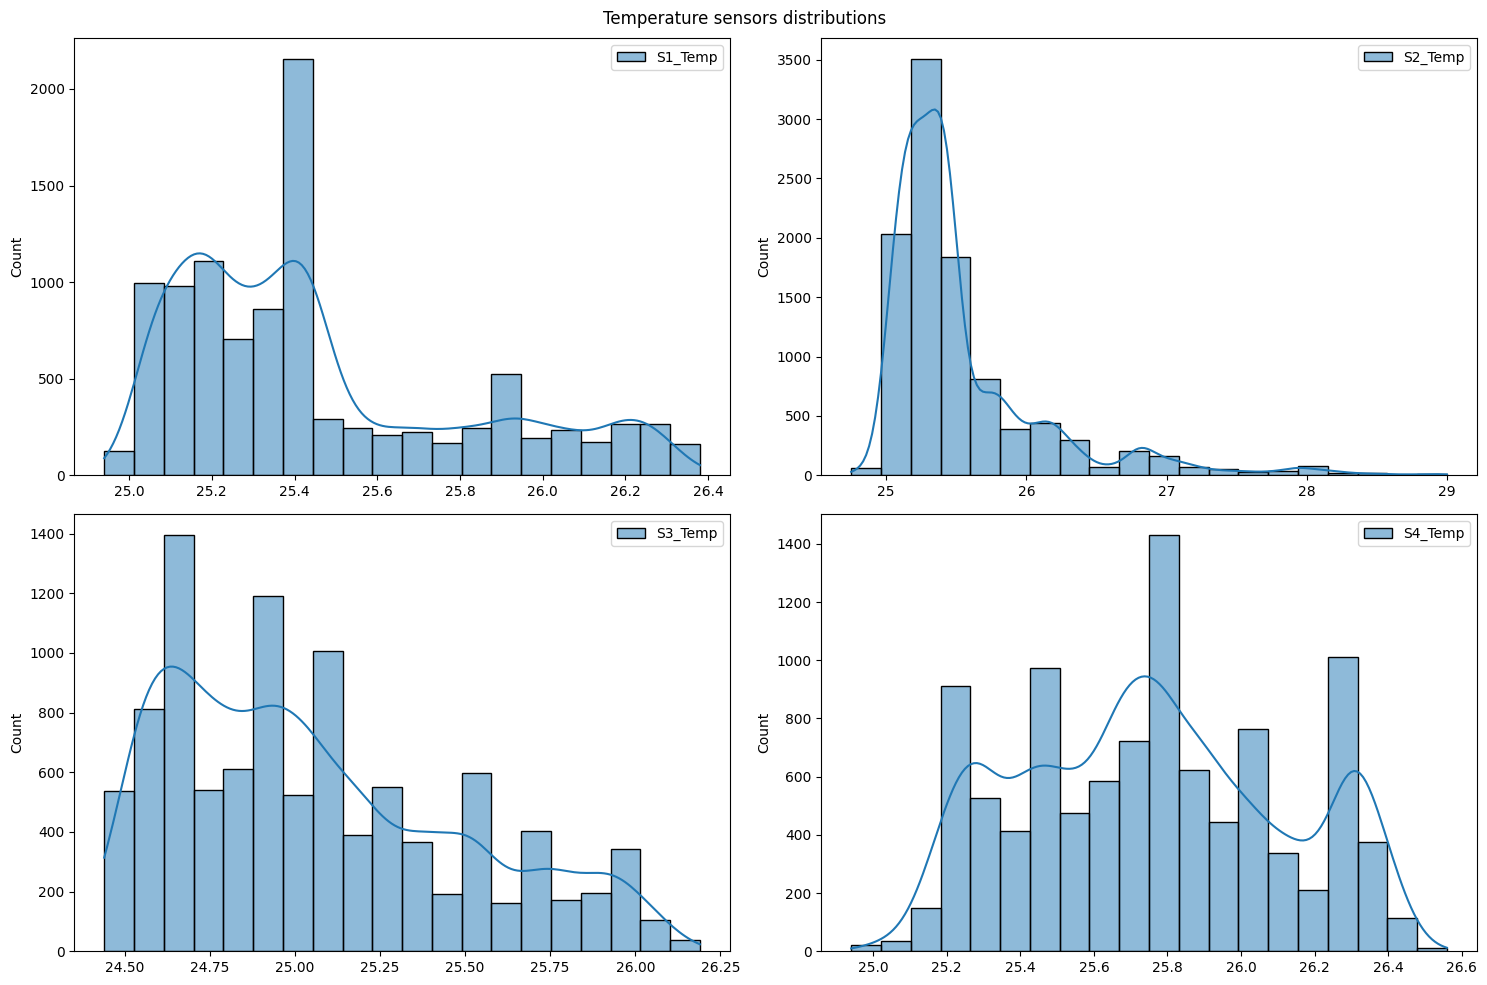

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle('Temperature sensors distributions')

axes_indices = [[0,0], [0,1], [1,0], [1,1]]
columns = ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp']

for col, ax_index in zip(columns, axes_indices):
    data = df.select(col).toPandas()
    r, c = ax_index
    sns.histplot(ax=axes[r, c], data=data, bins=20, kde = True)

plt.tight_layout()
plt.show()

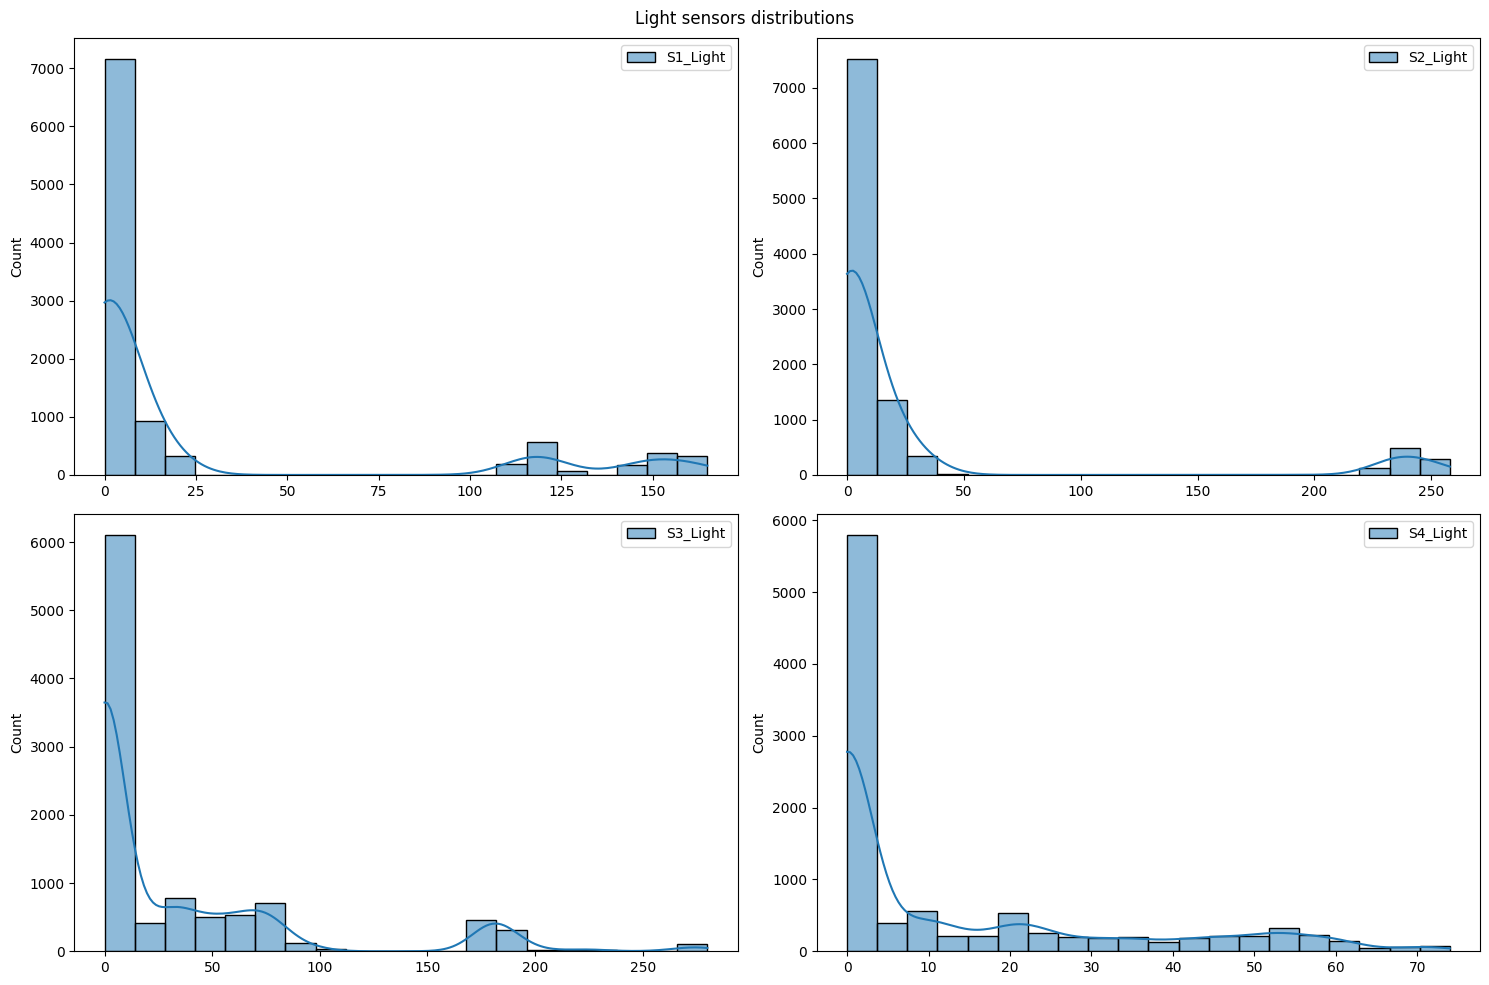

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle('Light sensors distributions')

axes_indices = [[0,0], [0,1], [1,0], [1,1]]
columns = ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']

for col, ax_index in zip(columns, axes_indices):
    data = df.select(col).toPandas()
    r, c = ax_index
    sns.histplot(ax=axes[r, c], data=data, bins=20, kde = True)

plt.tight_layout()
plt.show()

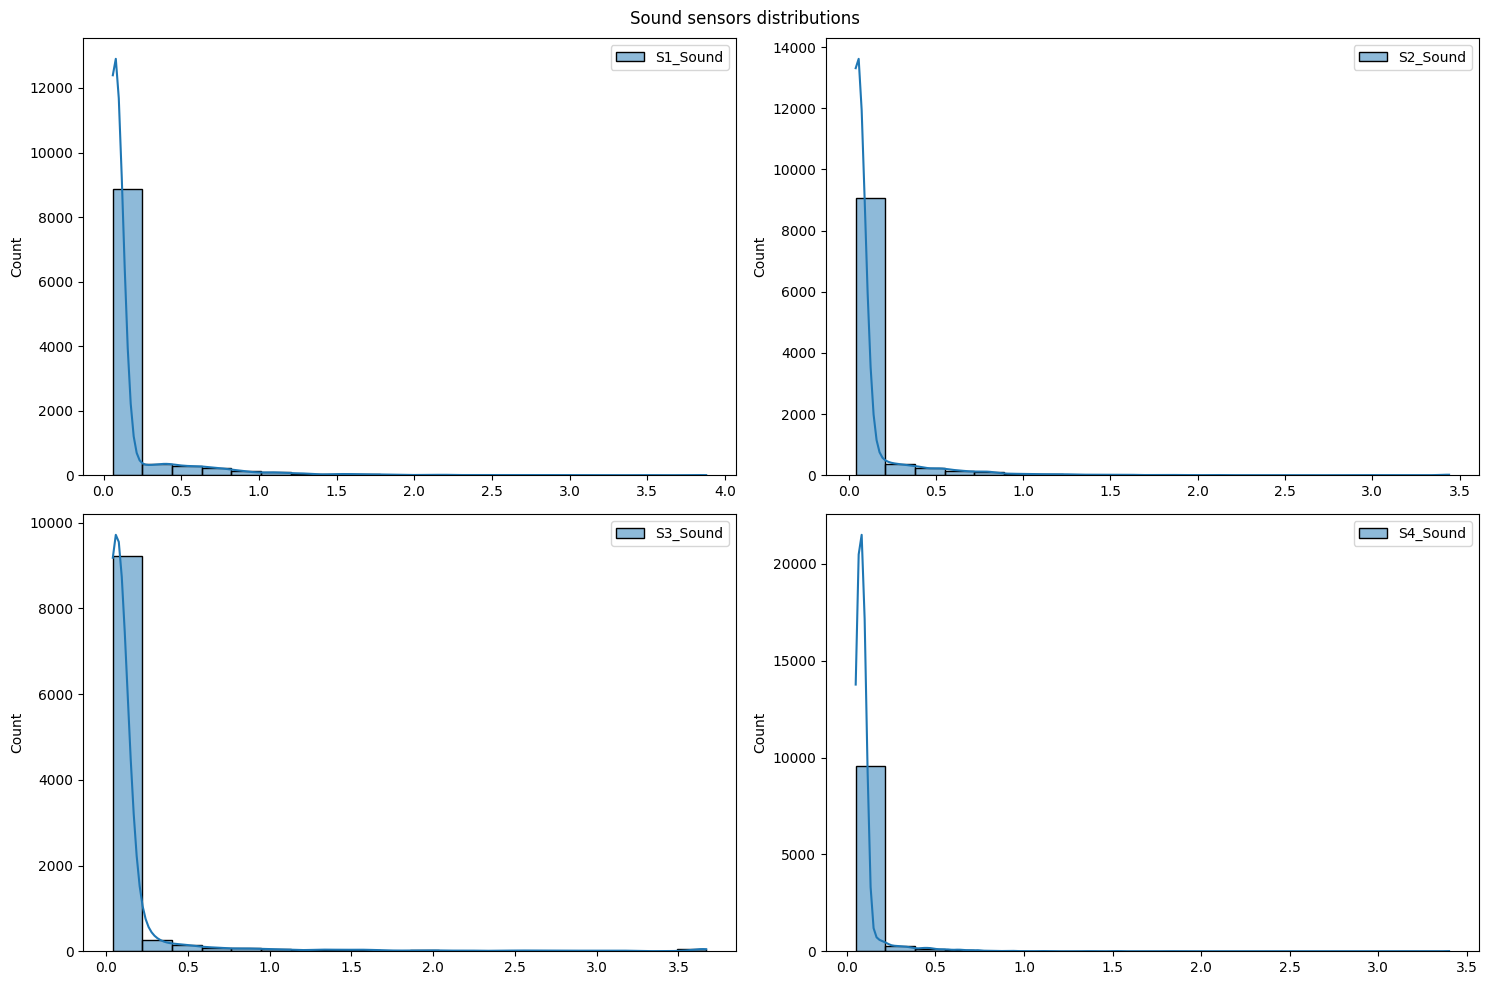

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle('Sound sensors distributions')

axes_indices = [[0,0], [0,1], [1,0], [1,1]]
columns = ['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']

for col, ax_index in zip(columns, axes_indices):
    data = df.select(col).toPandas()
    r, c = ax_index
    sns.histplot(ax=axes[r, c], data=data, bins=20, kde = True)

plt.tight_layout()
plt.show()

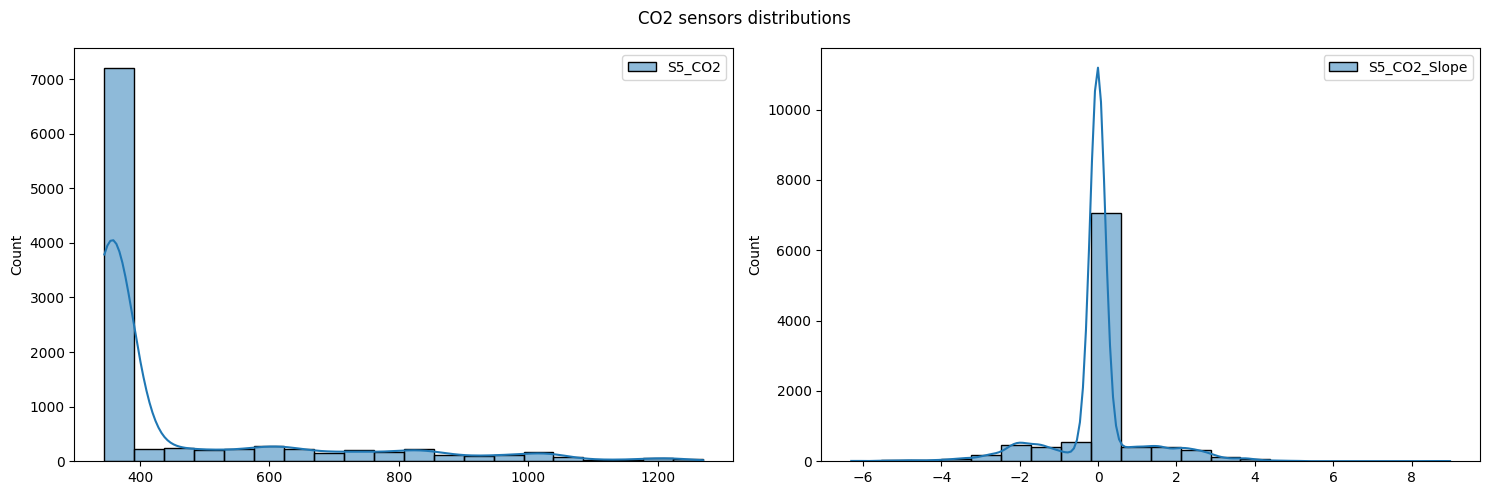

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('CO2 sensors distributions')

axes_indices = [0, 1]
columns = ['S5_CO2', 'S5_CO2_Slope']

for col, ax_index in zip(columns, axes_indices):
    data = df.select(col).toPandas()
    sns.histplot(ax=axes[ax_index], data=data, bins=20, kde = True)

plt.tight_layout()
plt.show()

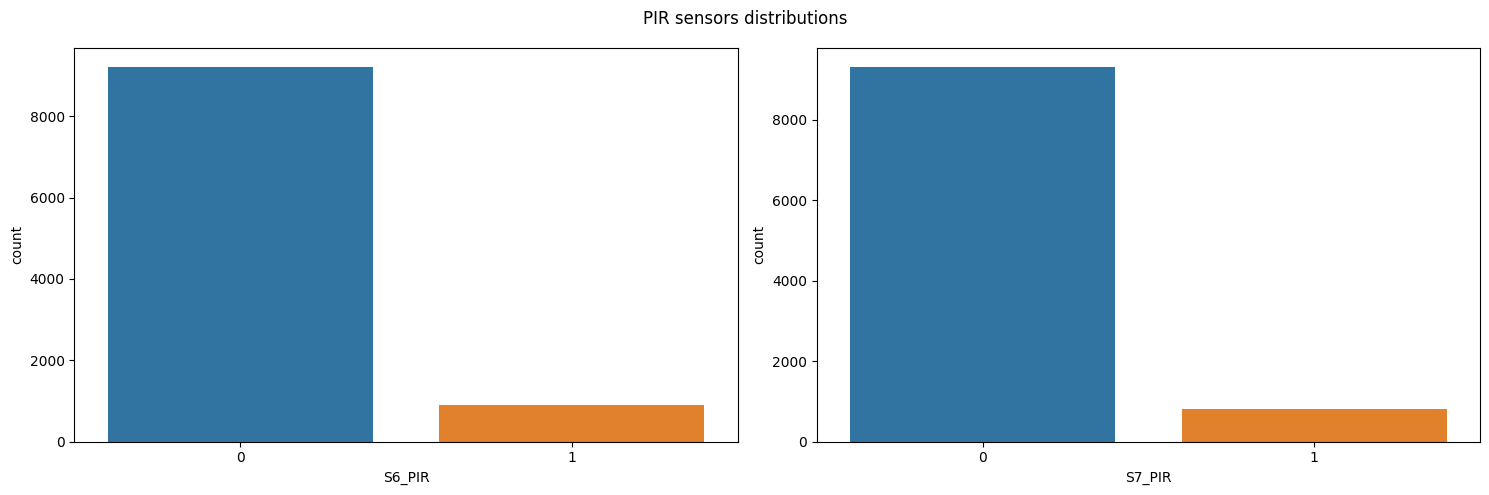

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('PIR sensors distributions')

axes_indices = [0, 1]
columns = ['S6_PIR', 'S7_PIR']

for col, ax_index in zip(columns, axes_indices):
    data = df.select(col).toPandas()
    sns.countplot(ax=axes[ax_index], data=data, x=col)

plt.tight_layout()
plt.show()

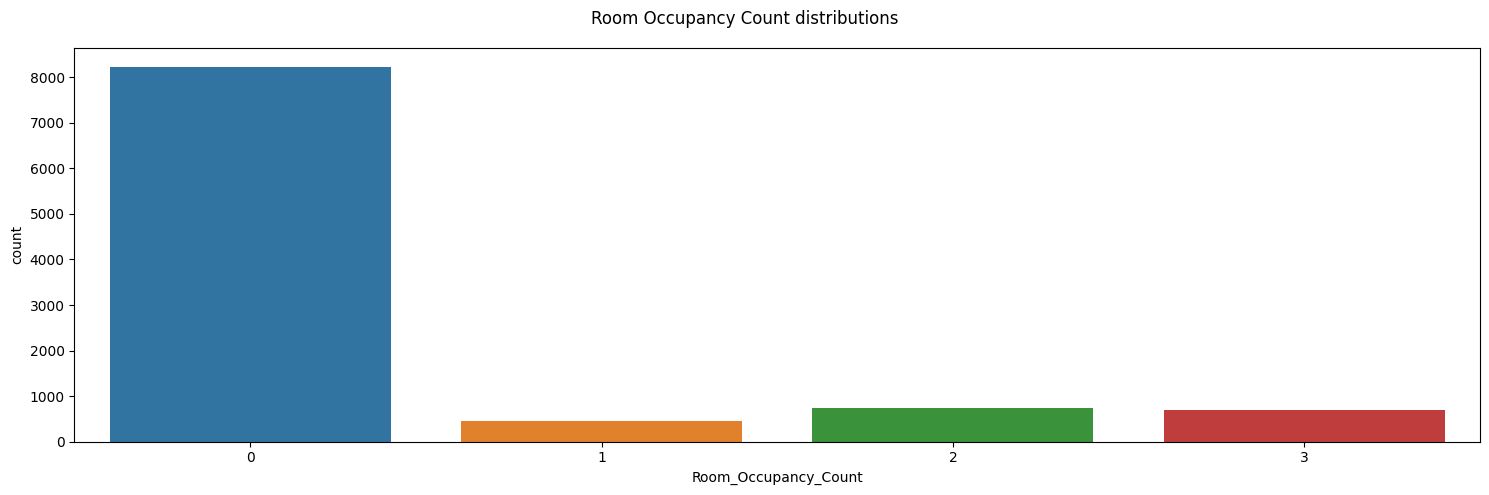

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 1, figsize=(15, 5))

fig.suptitle('Room Occupancy Count distributions')

col = 'Room_Occupancy_Count'

data = df.select(col).toPandas()
sns.countplot(ax=axes, data=data, x=col)

plt.tight_layout()
plt.show()

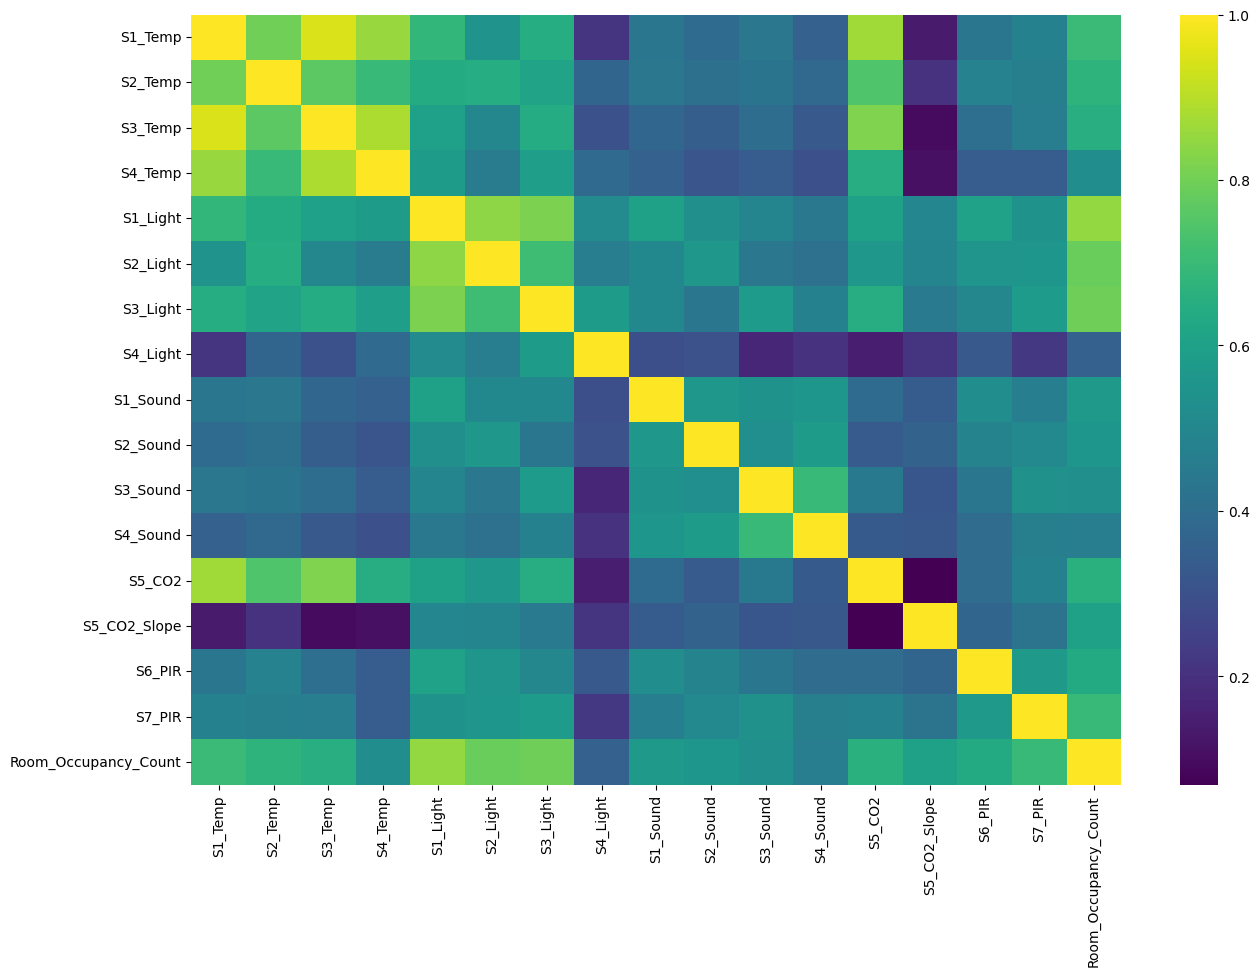

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize = (15,10))

spark.conf.set('spark.sql.legacy.timeParserPolicy', 'LEGACY')

sns.heatmap(df.toPandas().corr(numeric_only=True), cmap = 'viridis')

spark.conf.set('spark.sql.legacy.timeParserPolicy', 'EXCEPTION')

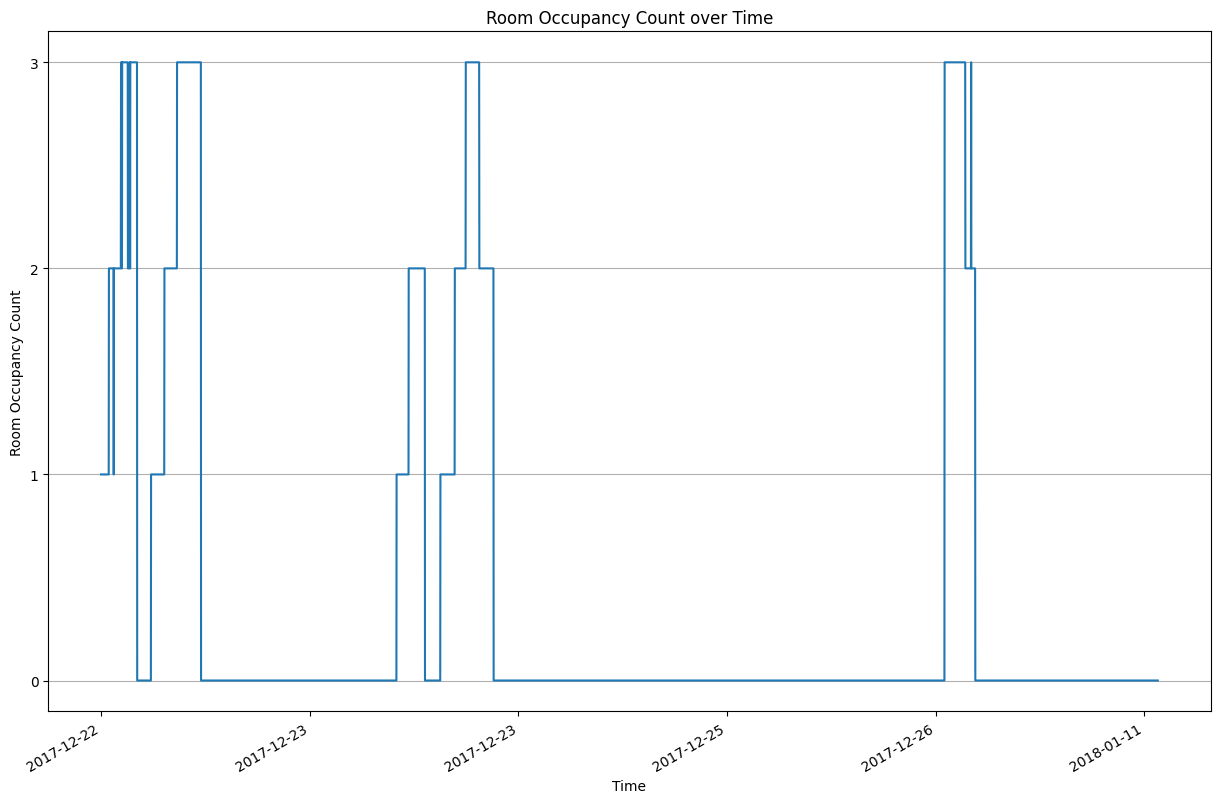

In [ ]:
import matplotlib.ticker as mticker
import pandas as pd


# Get pandas dataframe in terms of Date, Time and Room Occupancy Count.
pd_time_df = df.select('Date', 'Time', 'Room_Occupancy_Count').toPandas()

# Plot the timeseries.
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(range(len(pd_time_df.Date)), pd_time_df.Room_Occupancy_Count, '-')

# Set the dates in the xticks.
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
x_ticklabels = []
for tick in ax.get_xticks():
    try:
        x_ticklabels.append(pd_time_df.Date[int(tick)])
    except:
        x_ticklabels.append(tick)
ax.set_xticklabels(x_ticklabels)
fig.autofmt_xdate()

# Set the Room Occupancy Count in the yticks.
ax.set_yticks(pd_time_df.Room_Occupancy_Count.unique())

# Set the grid.
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()

# Set the title of the plot and of the axes.
plt.xlabel('Time')
plt.ylabel('Room Occupancy Count')
plt.title('Room Occupancy Count over Time')

# Show the plot.
plt.show()

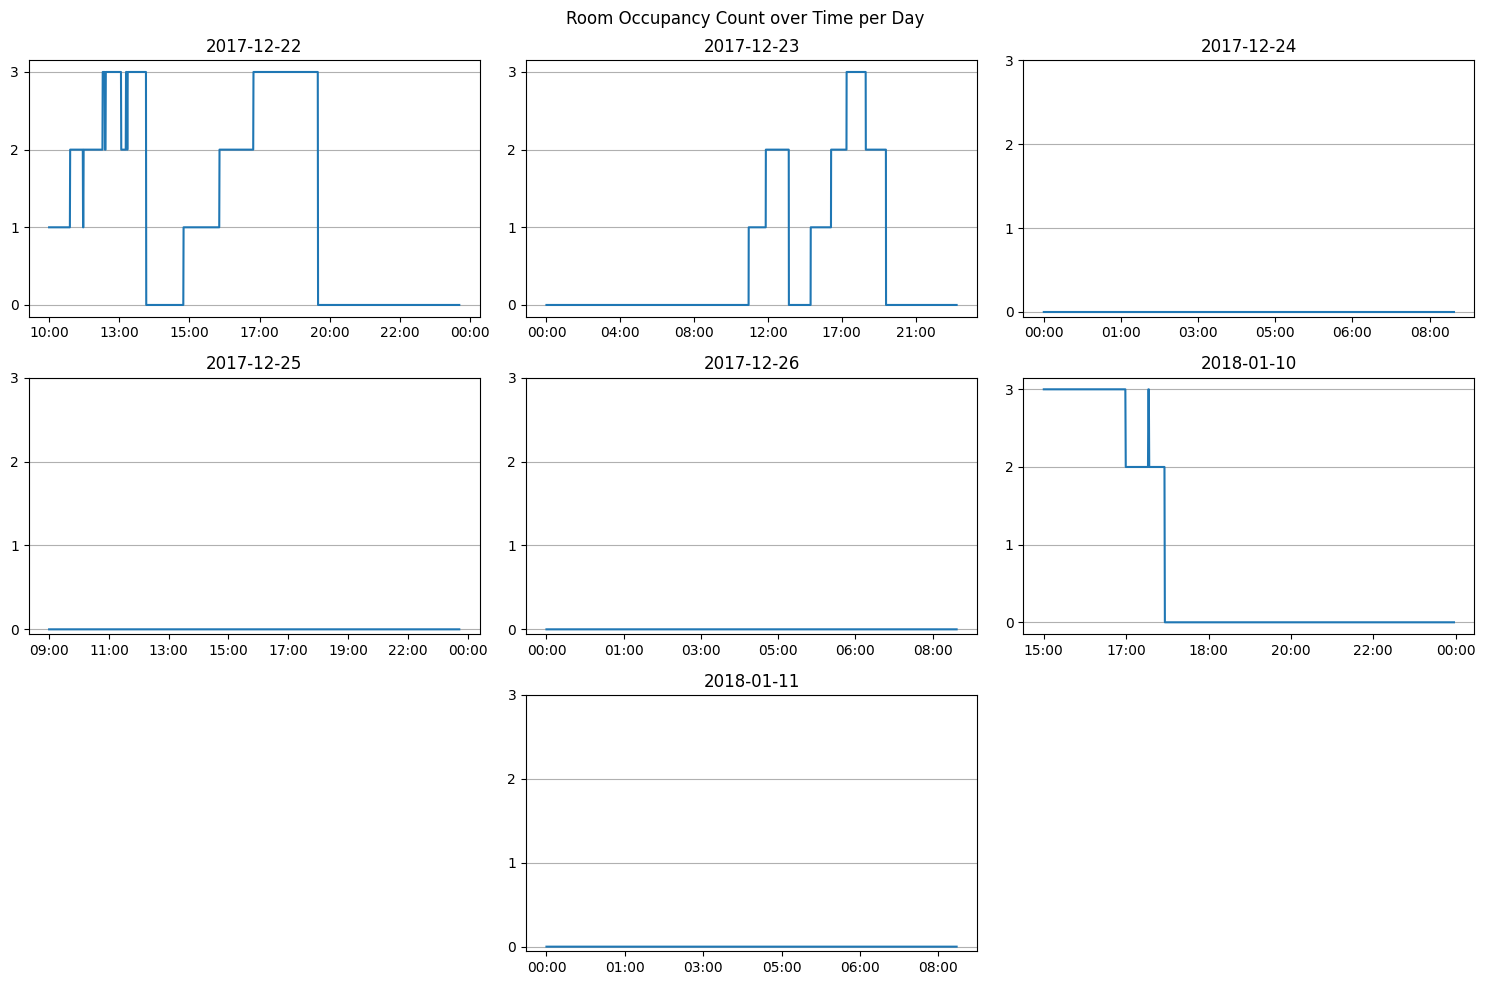

In [ ]:
import matplotlib.ticker as mticker
import pandas as pd


dates = [d.Date for d in df.select('Date').distinct().orderBy('Date').collect()]
distinct_labels = [
    c.Room_Occupancy_Count
    for c in df.select('Room_Occupancy_Count').distinct().orderBy('Room_Occupancy_Count').collect()]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

for i, d in enumerate(dates):
    # Select the ax.
    if i == len(dates) - 1:
        ax = axes[2,1]
    else:
        ax = axes[i // 3, i % 3]

    # Get the dataframe at the current date to pandas.
    day_df = df.where(F.col('Date') == d)
    pd_time_df = day_df.select('Time', 'Room_Occupancy_Count').toPandas()

    # Plot the timeseries.
    ax.plot(range(len(pd_time_df.Time)), pd_time_df.Room_Occupancy_Count, '-')

    # Set the times in the xticks.
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    x_ticklabels = []
    for tick in ax.get_xticks():
        try:
            x_ticklabels.append(f'{pd_time_df.Time[int(tick)].hour:02d}:00')
        except:
            x_ticklabels.append('00:00')
    ax.set_xticklabels(x_ticklabels)
    #ax.autofmt_xdate()

    # Set the Room Occupancy Count in the yticks.
    ax.set_yticks(distinct_labels)

    # Set the grid.
    ax.xaxis.grid(True, which="minor")
    ax.yaxis.grid()

    # Set the ax title.
    ax.set_title(d)

# Delete extra axes.
fig.delaxes(axes[2, 0])
fig.delaxes(axes[2, 2])

# Set the plot title.
plt.suptitle('Room Occupancy Count over Time per Day')

# Show the plot.
plt.tight_layout()
plt.show()

## Train and Test Split

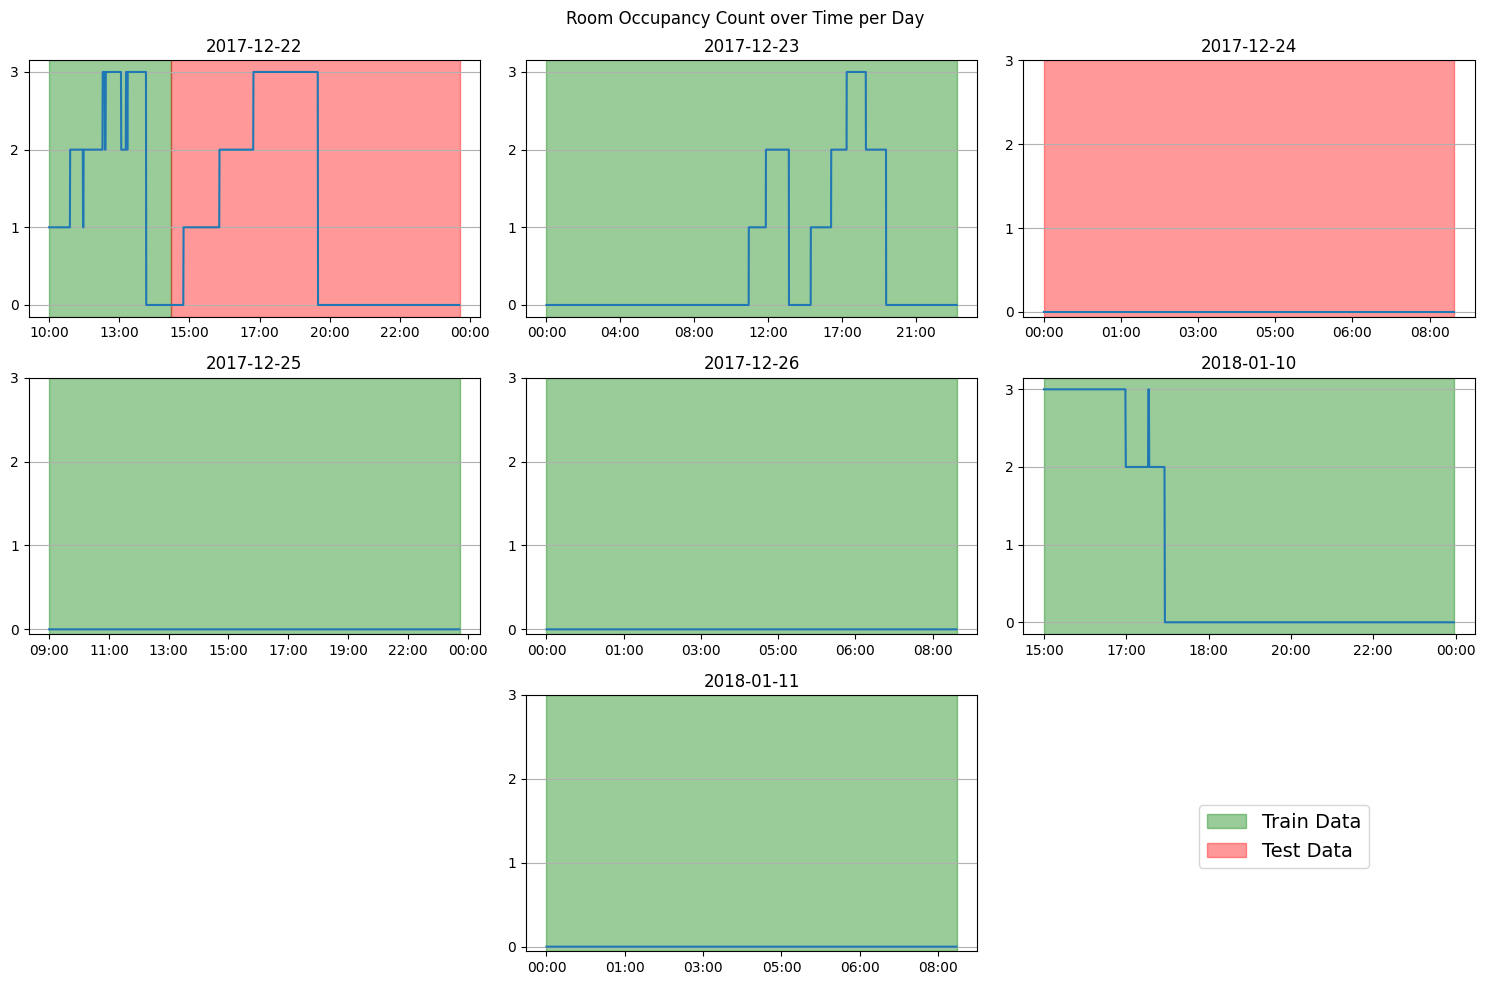

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import pandas as pd


dates = [d.Date for d in df.select('Date').distinct().orderBy('Date').collect()]
distinct_labels = [
    c.Room_Occupancy_Count
    for c in df.select('Room_Occupancy_Count').distinct().orderBy('Room_Occupancy_Count').collect()]
date_1_min_hour = 14

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

for i, d in enumerate(dates):
    # Select the ax.
    if i == len(dates) - 1:
        ax = axes[2,1]
    else:
        ax = axes[i // 3, i % 3]

    # Get the dataframe at the current date to pandas.
    day_df = df.where(F.col('Date') == d)
    pd_time_df = day_df.select('Time', 'Room_Occupancy_Count').toPandas()

    # Plot the timeseries.
    ax.plot(range(len(pd_time_df.Time)), pd_time_df.Room_Occupancy_Count, '-')

    # Set the times in the xticks.
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    x_ticklabels = []
    for tick in ax.get_xticks():
        try:
            x_ticklabels.append(f'{pd_time_df.Time[int(tick)].hour:02d}:00')
        except:
            x_ticklabels.append('00:00')
    ax.set_xticklabels(x_ticklabels)

    # Higlight the splits
    if i == 0:
        test_idx = pd_time_df.Time[pd_time_df['Time'].apply(lambda x: x.hour) > date_1_min_hour].index[0]
        ax.axvspan(0, test_idx, alpha=0.4, color='green')
        ax.axvspan(test_idx, len(pd_time_df.Time), alpha=0.4, color='red')
    elif i == 2:
        ax.axvspan(0, len(pd_time_df.Time), alpha=0.4, color='red')
    else:
        ax.axvspan(0, len(pd_time_df.Time), alpha=0.4, color='green')

    # Set the Room Occupancy Count in the yticks.
    ax.set_yticks(distinct_labels)

    # Set the grid.
    ax.xaxis.grid(True, which="minor")
    ax.yaxis.grid()

    # Set the ax title.
    ax.set_title(d)

# Delete extra axes.
fig.delaxes(axes[2, 0])
fig.delaxes(axes[2, 2])

# Set the plot title.
plt.suptitle('Room Occupancy Count over Time per Day')

# Set the legend.
train_patch = mpatches.Patch(color='green', alpha=.4, label='Train Data')
test_patch = mpatches.Patch(color='red', alpha=.4, label='Test Data')
fig.legend(
    handles=[train_patch, test_patch],
    loc='lower right',
    prop={'size': 14},
    borderaxespad=6.)

# Show the plot.
plt.tight_layout()
plt.show()

In [ ]:
from typing import Tuple
from pyspark.sql import DataFrame

def train_test_split(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    # Get the dates list.
    dates_list = df.select('Date').distinct().orderBy('Date').collect()
    # Get
    date_1, date_2 = dates_list[0].Date, dates_list[2].Date
    date_1_min_hour = 14

    test = df.where(
        ((F.col('Date') == date_1) & (F.hour(df.Time) > date_1_min_hour)) |
         (F.col('Date') == date_2))
    train =  df.where(
        ((F.col('Date') == date_1) & (F.hour(df.Time) <= date_1_min_hour)) |
        ((F.col('Date') != date_1) & (F.col('Date') != date_2)))
    return train, test

In [ ]:
train, test = train_test_split(df)

In [ ]:
print('Number of train instances:', train.count())
print('Number of test instances:', test.count())

Number of train instances: 8036
Number of test instances: 2093


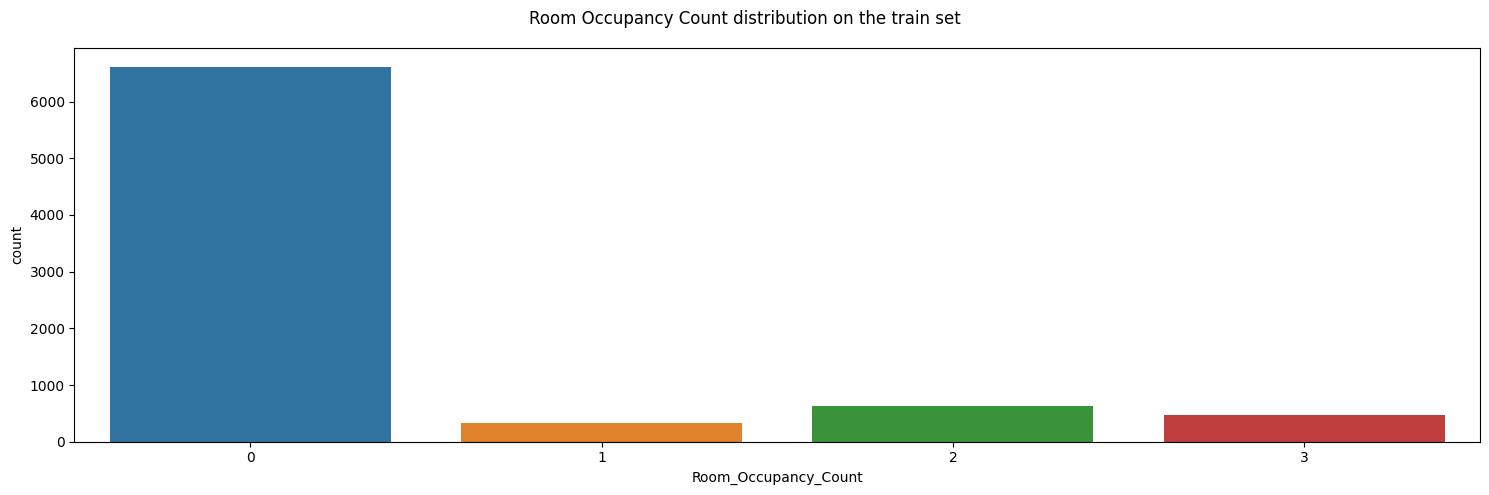

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('Room Occupancy Count distribution on the train set')

col = 'Room_Occupancy_Count'

data = train.select(col).toPandas()
sns.countplot(ax=axes, data=train.toPandas(), x=col)

plt.tight_layout()
plt.show()

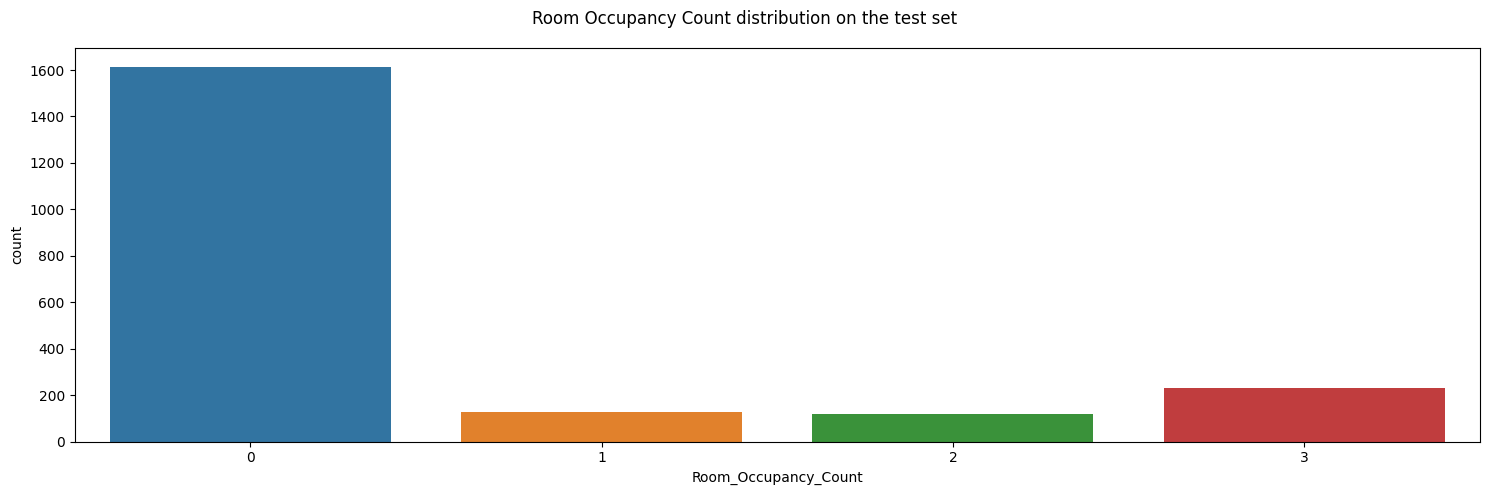

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 1, figsize=(15, 5))

fig.suptitle('Room Occupancy Count distribution on the test set')
col = 'Room_Occupancy_Count'

data = test.select(col).toPandas()
sns.countplot(ax=axes, data=test.toPandas(), x=col)

plt.tight_layout()
plt.show()

In [ ]:
import os


# Get the train and test datasets.
train_path = os.path.join('input', 'processed', 'train')
train.coalesce(1).write.mode('overwrite').options(header=True, delimiter=',').csv(train_path)

test_path = os.path.join('input', 'processed', 'test')
test.coalesce(1).write.mode('overwrite').options(header=True, delimiter=',').csv(test_path)

In [ ]:
import os
import shutil
import sys

# Move the results in the processed folder.
if 'google.colab' in sys.modules:
    source_path = os.path.join('input', 'processed', 'train')
    destination_path = os.path.join('input', 'processed', 'train.csv')
    source_list = os.listdir(source_path)
    for file in source_list:
        if file.endswith('.csv'):
            shutil.move(os.path.join(source_path, file), destination_path)

    shutil.rmtree(source_path)

    source_path = os.path.join('input', 'processed', 'test')
    destination_path = os.path.join('input', 'processed', 'test.csv')
    source_list = os.listdir(source_path)
    for file in source_list:
        if file.endswith('.csv'):
            shutil.move(os.path.join(source_path, file), destination_path)

    shutil.rmtree(source_path)

# Move the results from node to local.
else:
    !mkdir input
    !mkdir input/processed
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -get -f input/processed/train/*.csv input/processed/train.csv
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -get -f input/processed/test/*.csv input/processed/test.csv
